Run this to make sure the DL at the end works.

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Mount drive and change to working directory.

In [0]:
from google.colab import drive
drive.mount("/content/drive/")
%cd 'drive/My Drive/MIR'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/MIR


Load Turkish Dataset (Tr-music-dataset - songs from 4 emotion classes mapped to the AV plane) - !!! Go straight to "Load .csv files into DataFrames." if you want to load directly the pre-extracted features.

In [0]:
import os, sys, shutil
from pathlib import Path

main_data_dir = 'tr-music-dataset'
#Dictionary containing for each emotion class a list that carries dictionaries
inst_files = dict() 
for root, dirs, files in os.walk(main_data_dir):
    for file in files:
      if file.endswith('mp3'):
        file_name = os.path.join(root,file)
        path = Path(file_name)
        parent=str(path.parent)
        emotion = parent.split(os.sep)[1]
        files_emotion = inst_files.get(emotion)
        if files_emotion == None:
          files_emotion = [file_name]
        else:
          files_emotion.append(file_name)
        inst_files[emotion] = files_emotion

Plot sample waveform for each emotion class.

Sample waveform plots


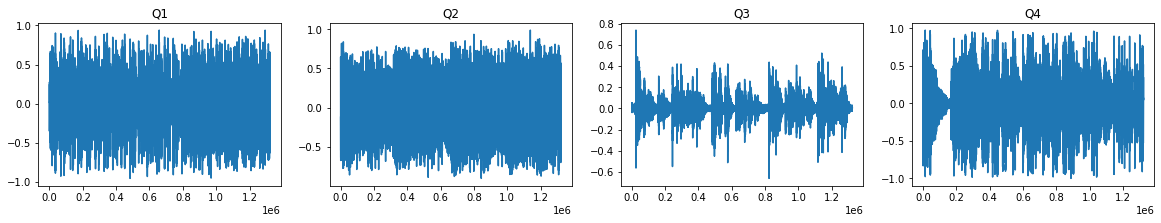

In [0]:
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia
import matplotlib.pyplot as plt
import essentia.standard as ess

# Raw-data preprocess analysis parameters
fs = 44100
num_emotion = len(inst_files.keys())
print("Sample waveform plots")
plt.figure(1, figsize=(5 * num_emotion, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
key_order = ['Q1', 'Q2', 'Q3', 'Q4']
for i,emotion in enumerate(key_order):
    sample_file = inst_files[emotion][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()  
    plt.subplot(1,num_emotion,(i+1))
    plt.plot(x)
    plt.title(emotion)

Check if dataset is balanced.


In [0]:
# Check data is balanced
for key in inst_files.keys():
    print(key, ': ', len(inst_files[key]), ' samples \n')

Q2 :  100  samples 

Q1 :  100  samples 

Q3 :  100  samples 

Q4 :  100  samples 



Split samples into train set and test set.

In [0]:
# Put into X and y arrays.
X = []
y = []
for emotion, files in inst_files.items():
    for file in files:
        X.append(file)
        y.append(emotion)

# Split data into test and train sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("Size of train set: ", len(X_train), ", Size of train output vector: ", len(y_train))
print("Size of test set: ", len(X_test), ", Size of test output vector: ", len(y_test))

Size of train set:  320 , Size of train output vector:  320
Size of test set:  80 , Size of test output vector:  80


Divide each sample into 4 segments and save them to appropriate train or test segments folder. - !!! The next 2 cells take some time to run, you can straight to "Load .csv files into DataFrames." if the segments folders are already created.

In [0]:
# Create segments
import numpy as np

train_segments_dir = os.path.join(main_data_dir,'train_segments')
if not os.path.exists(train_segments_dir):#creating the directory
    os.mkdir(train_segments_dir)
test_segments_dir = os.path.join(main_data_dir,'test_segments')
if not os.path.exists(test_segments_dir):#creating the directory
    os.mkdir(test_segments_dir)

fs = 44100
file_count = 0
train_segment_files = []
test_segment_files = []
for i, file in enumerate(X):
    emotion = y[i]
    segments_dir = train_segments_dir if file in X_train else test_segments_dir
    x = ess.MonoLoader(filename = file, sampleRate = fs)()
    #Split song in 4 segments 
    split = (int)(len(x)/4)
    x_seg = [x[:split], x[split:2*split], x[2*split:3*split], x[3*split:]]
    for seg in x_seg:
        #Amplitude normalisation
        seg = seg / np.max(np.abs(seg))
        filename = os.path.join(segments_dir, emotion + '_' + str(file_count) + '.wav')
        ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(seg)
        file_count +=1
        train_segment_files.append(filename) if file in X_train else test_segment_files.append(filename)
print(len(train_segment_files),'segment files created')
print(len(test_segment_files),'segment files created')

1280 segment files created
320 segment files created


Feature extraction with Essentia - only low level descriptors are used.

In [0]:
#Running music extractor for a file
file = train_segment_files[0]#simply pick the first file in the list
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]

#Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = os.path.join(train_segments_dir,'train_data.csv')
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['emotion']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in train_segment_files:
            features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            emotion = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + emotion + '\n'
            writer.write(line2write)
# same for test set
data_file = os.path.join(test_segments_dir,'test_data.csv')
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['emotion']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in test_segment_files:
            features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            emotion = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + emotion + '\n'
            writer.write(line2write)

Load .csv files into DataFrames.

In [9]:
# Analysis of features
import pandas as pd

train_file = 'tr-music-dataset/train_segments/train_data.csv' # Uncomment this if .csv already created
test_file = 'tr-music-dataset/test_segments/test_data.csv' # Uncomment this if .csv already created
#Read data
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
print("Data is null:")
print(train_data.isnull().sum().sum())#sums a matrix of True/False values obtained by checking if each value is Nan
print(test_data.isnull().sum().sum())#sums a matrix of True/False values obtained by checking if each value is Nan

Data is null:
0
0


Normalize features.

In [0]:
# Normalization of features
train_data_modif = train_data.copy()
test_data_modif = test_data.copy()
#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
train_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(train_data.iloc[:,:84].values)
test_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(test_data.iloc[:,:84].values)

Check how balanced is the data in train set.


In [11]:
print(train_data_modif.emotion.value_counts())

q1    328
q4    328
q3    328
q2    296
Name: emotion, dtype: int64


In [12]:
# Balancing data
data_modif = train_data_modif
min_number = data_modif.emotion.value_counts()['q2']
q2_data = data_modif[data_modif.emotion == 'q2'].sample(n = min_number)
q1_data = data_modif[data_modif.emotion == 'q1'].sample(n = min_number, random_state = 42)
q3_data = data_modif[data_modif.emotion == 'q3'].sample(n = min_number, random_state = 42)
q4_data = data_modif[data_modif.emotion == 'q4'].sample(n = min_number, random_state = 42)

#Merging after downsampling
train_data_modif = pd.concat([q1_data, q2_data, q3_data, q4_data])
#Checking the balance again
train_data_modif.emotion.value_counts()

q2    296
q1    296
q4    296
q3    296
Name: emotion, dtype: int64

Feature selection

In [13]:
import numpy as np
from numpy import set_printoptions

# Preparing data arrays for features and labels
#input values put in a matrix, there are 84 features
X_train = train_data_modif.iloc[:,:84].values 
X_test = test_data_modif.iloc[:,:84].values 
#Creating output values
train_data_modif.emotion = pd.Categorical(train_data_modif.emotion)#convert to categorical data
test_data_modif.emotion = pd.Categorical(test_data_modif.emotion)#convert to categorical data
y_train = np.array(train_data_modif.emotion.cat.codes) #create label encoded outputs
y_test = np.array(test_data_modif.emotion.cat.codes) #create label encoded outputs

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2

z = SelectKBest(chi2, k=50)
fit = z.fit(X_train, y_train)
# summarize scores
set_printoptions(precision=3)
ten = fit.scores_.argsort()[-10:][::-1] # 10 best features selected 

X_train = fit.transform(X_train)
X_test = fit.transform(X_test)   # only consider selected features from the training set
print('X_train shape is ', X_train.shape)
print('X_test shape is ', X_test.shape, '\n')

print('Top 10 selected features: ')
for i in ten:
    print(train_data_modif.keys()[i])

X_train shape is  (1184, 50)
X_test shape is  (320, 50) 

Top 10 selected features: 
silence_rate_30dB.stdev
spectral_centroid.mean
spectral_skewness.stdev
melbands_spread.mean
spectral_kurtosis.stdev
silence_rate_60dB.stdev
barkbands_spread.mean
zerocrossingrate.mean
barkbands_flatness_db.mean
spectral_kurtosis.mean


Analysis of best 2 features 

Silence rate 30dB stdev x Spectral centroid mean:


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


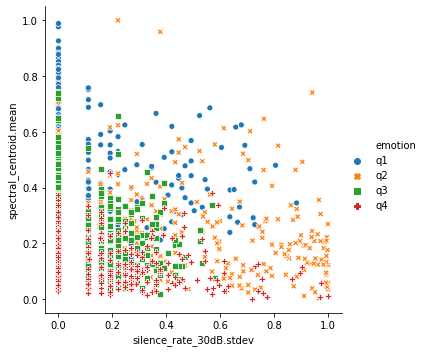

In [14]:
# Plot samples on two-dimensional feature spaces to check if features are discriminative
import seaborn as sns

print("Silence rate 30dB stdev x Spectral centroid mean:")
sns.relplot(x = "silence_rate_30dB.stdev", y = "spectral_centroid.mean", hue = "emotion", style = "emotion", data = train_data_modif);

Comparison of traditional Machine Learning Classifiers - !!! This cell takes some time to run - the best model is implemented in the next cell.

In [15]:
import warnings
warnings.filterwarnings('ignore')#suppress warnings
#importing various classifiers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma = 1 / (X_train.shape[-1] * X_train.var())),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB(),
    RandomForestClassifier(max_depth=15, random_state=0)]

names = ["KNN", "Linear SVM", "RBF SVM", "Gaussian Process","Neural Net", "Naive Bayes", "Random Forest"]

#Creating empty list of scores for each classifier, we will append test results to these lists 
scores = {}
for name in names:
    scores[name] = []

#Let's run 10 random experiments, collect scores for each classifier 
num_tests = 10
for iteration_number in range(num_tests):
    x_train_val, x_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size = 1/num_tests, random_state = iteration_number)
    #normalisation of the data (learned from training data, applied to test data)
    scaler = StandardScaler().fit(x_train_val)
    norm_x_train = scaler.transform(x_train_val)
    norm_x_val = scaler.transform(x_val)
    
    # test over each classifier
    for name, clf in zip(names, classifiers):
        clf.fit(norm_x_train, y_train_val)#train
        score = clf.score(norm_x_val, y_val)#test
        scores[name].append(score)

for name, score in scores.items():
    print("{0}: acc = {1:1.2f}, +-{2:1.2f},\tvalues: {3}".format(name, np.mean(score), np.std(score), np.around(score, decimals = 2)))

KNN: acc = 0.80, +-0.04,	values: [0.81 0.82 0.75 0.8  0.73 0.81 0.75 0.84 0.87 0.85]
Linear SVM: acc = 0.80, +-0.04,	values: [0.78 0.78 0.76 0.81 0.72 0.8  0.84 0.8  0.83 0.86]
RBF SVM: acc = 0.71, +-0.06,	values: [0.79 0.72 0.62 0.63 0.74 0.74 0.64 0.76 0.7  0.75]
Gaussian Process: acc = 0.88, +-0.03,	values: [0.87 0.82 0.83 0.89 0.88 0.88 0.88 0.92 0.89 0.93]
Neural Net: acc = 0.87, +-0.04,	values: [0.87 0.82 0.79 0.87 0.89 0.85 0.89 0.87 0.88 0.93]
Naive Bayes: acc = 0.68, +-0.04,	values: [0.64 0.63 0.64 0.71 0.66 0.7  0.73 0.7  0.67 0.73]
Random Forest: acc = 0.83, +-0.04,	values: [0.82 0.75 0.78 0.87 0.82 0.82 0.83 0.85 0.87 0.89]


Report results for the best classifier

Number of test samples:  320
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        72
           1       0.87      0.72      0.79       104
           2       0.71      0.57      0.63        72
           3       0.55      0.76      0.64        72

    accuracy                           0.69       320
   macro avg       0.70      0.69      0.69       320
weighted avg       0.72      0.69      0.70       320

Confusion matrix: 



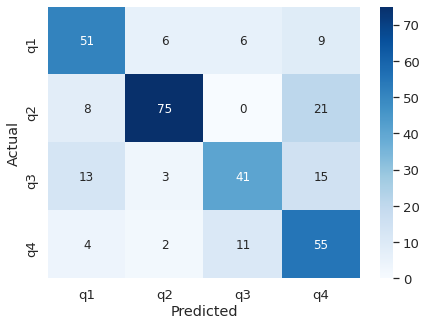

In [16]:
from sklearn.neural_network import MLPClassifier
selected_model = MLPClassifier(alpha=1, max_iter=1000)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("Confusion matrix: \n")
classes = np.unique(test_data_modif.emotion)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");

Deep Learning

In [17]:
# Define deep learning architecture
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 4))
    model.add(layers.Activation('sigmoid'))
    
    return model

Using TensorFlow backend.


Shuffle train data and apply one hot encoding to output values.

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train_val, y_train_val = shuffle(X_train, y_train, random_state=13)

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (1184, 4)
One-hot encoded y_test shape =  (320, 4)


Run DL model





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (BatchNormalizati (None, 50)                200       
_________________________________________________________________
HiddenLayer_1 (Dense)        (None, 40)                2040      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40)                160       
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
HiddenLayer_2 (Dense)        (None, 20)                820       
_

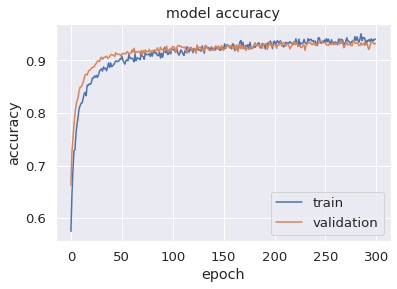

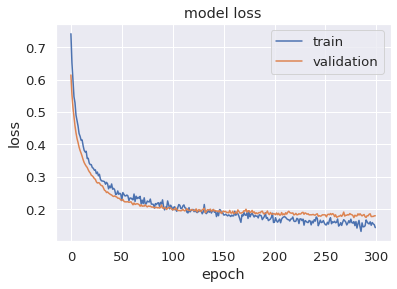

In [19]:
model = compose_model(X_train_val.shape[1])
model.summary()

model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 80, epochs = 300, validation_split=0.2, verbose=0,)

# Test
score = model.evaluate(X_test, y_test_onehot, batch_size = 80, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
 
# Check the learning curves
# summarize history for accuracy
plt.plot(summary.history['acc'])
plt.plot(summary.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

              precision    recall  f1-score   support

           0       0.78      0.44      0.57        72
           1       1.00      0.37      0.54       104
           2       0.50      0.76      0.60        72
           3       0.42      0.76      0.54        72

    accuracy                           0.56       320
   macro avg       0.67      0.58      0.56       320
weighted avg       0.71      0.56      0.56       320

Confusion matrix: 



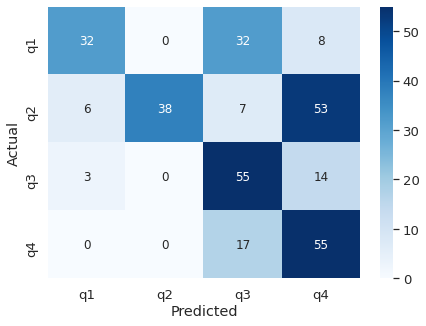

In [20]:
y_pred = model.predict_classes(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("Confusion matrix: \n")
classes = np.unique(test_data_modif.emotion)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");